In [191]:
## Importing required packages
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [192]:
## Building an example dataframe
df = pd.DataFrame()
df['Age'] = [25,35,45,25]
df['Pizza'] = [1,1,0,1]
df['City'] = ['New Delhi','Bangalore','Bangalore','Mumbai']
df['Fit'] = ['F','NF','F','F']
df

,Age,Pizza,City,Fit
0,25,1,New Delhi,F
1,35,1,Bangalore,NF
2,45,0,Bangalore,F
3,25,1,Mumbai,F


In [193]:
## Subsetting dataframe for columns that do not need to be label encoded
df1 = df[['Age','Pizza','Fit']]

## Subsetting dataframe for columns that need to be label encoded
df2 = pd.get_dummies(df['City'])
df2

,Bangalore,Mumbai,New Delhi
0,0,0,1
1,1,0,0
2,1,0,0
3,0,1,0


In [194]:
## Joining the label encoded features to the remaining dataframe
df3 = df1.join(df2)

## Reordering columns to get the features at the start and the target variable at the end
df3 = df3[['Age','Pizza','Bangalore','Mumbai','New Delhi','Fit']]
df3

,Age,Pizza,Bangalore,Mumbai,New Delhi,Fit
0,25,1,0,0,1,F
1,35,1,1,0,0,NF
2,45,0,1,0,0,F
3,25,1,0,1,0,F


## Section 1: Toy example from A Super Simple Explanation to Random Forest Classifier

### Step 1. Give different weights to observations in each tree

#### Building the first Decision Tree

In [195]:
## Creating the first bootstrapped dataset (randomly repeating Row 2 and leaving out Row 0)
bootstrapped_df1 = df3.iloc[1:,:].append(df3.iloc[2,:])
bootstrapped_df1

,Age,Pizza,Bangalore,Mumbai,New Delhi,Fit
1,35,1,1,0,0,NF
2,45,0,1,0,0,F
3,25,1,0,1,0,F
2,45,0,1,0,0,F


In [196]:
## Randomly subsetting 2 features for our first bootstrapped dataset
bootstrapped_df1 = bootstrapped_df1[['Pizza','New Delhi','Fit']]
bootstrapped_df1

,Pizza,New Delhi,Fit
1,1,0,NF
2,0,0,F
3,1,0,F
2,0,0,F


In [197]:
## Create feature set
feats1 = list(bootstrapped_df1.columns)
feats1.remove('Fit')
feats1

['Pizza', 'New Delhi']

In [198]:
## Create Decision Tree classifer object
clf1 = DecisionTreeClassifier(random_state=105)

## Train Decision Tree Classifer
X_train = bootstrapped_df1[feats1]
y_train = bootstrapped_df1['Fit']
clf1 = clf1.fit(X_train, y_train)

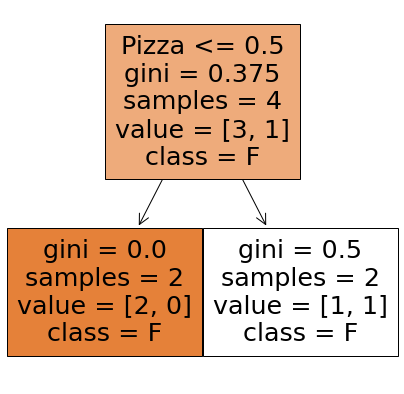

In [199]:
## Plot Decision Tree from second boostrapped dataset
fig = plt.figure(figsize=(7,7))
_ = tree.plot_tree(clf1, 
                   feature_names=list(feats1),
                   class_names=['F','NF'],
                   filled=True)

#### Building the second Decision Tree

In [200]:
## Creating the second bootstrapped dataset (randomly repeating Row 2 and leaving out Row 3)
bootstrapped_df2 = df3.iloc[:3,:].append(df3.iloc[2,:])
bootstrapped_df2

,Age,Pizza,Bangalore,Mumbai,New Delhi,Fit
0,25,1,0,0,1,F
1,35,1,1,0,0,NF
2,45,0,1,0,0,F
2,45,0,1,0,0,F


In [201]:
## Randomly subsetting 2 features for our second bootstrapped dataset
bootstrapped_df2 = bootstrapped_df2[['Age','Bangalore','Fit']]
bootstrapped_df2

,Age,Bangalore,Fit
0,25,0,F
1,35,1,NF
2,45,1,F
2,45,1,F


In [202]:
## Create feature set
feats2 = list(bootstrapped_df2.columns)
feats2.remove('Fit')
feats2

['Age', 'Bangalore']

In [203]:
## Create Decision Tree classifer object
clf2 = DecisionTreeClassifier(random_state=105)

## Train Decision Tree Classifer
clf2 = clf2.fit(bootstrapped_df2[feats2],bootstrapped_df2['Fit'])

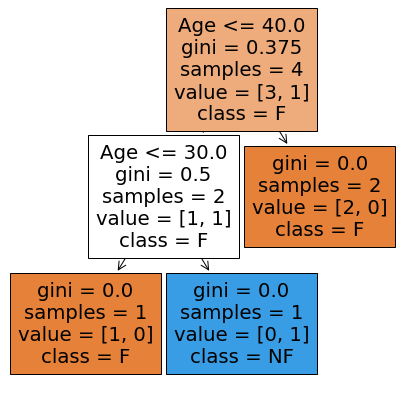

In [204]:
## Plot Decision Tree from second boostrapped dataset
fig = plt.figure(figsize=(7,7))
_ = tree.plot_tree(clf2, 
                   feature_names=list(feats2),
                   class_names=['F','NF'],
                   filled=True)

### Step 2. Aggregate predictions from trees

In [205]:
## Building the OOB dataset
oob_df = df3.iloc[[0,3],:]
oob_df

,Age,Pizza,Bangalore,Mumbai,New Delhi,Fit
0,25,1,0,0,1,F
3,25,1,0,1,0,F


In [206]:
## The first Decision Tree predicts Fit for both individuals
clf1.predict(oob_df[feats1])

array(['F', 'F'], dtype=object)

In [207]:
## The second Decision Tree also predicts Fit for both individuals
clf2.predict(oob_df[feats2])

array(['F', 'F'], dtype=object)

As noted in the blog, the predictions from both Decision Trees are the same because they ultimately make use of only two features; Pizza and Age; both of which are the same for the two individuals.

Since the predictions are unanimous, aggregating the predictions also results in F, F.

## Section 2: Building a Random Forest Classifier


In [208]:
## Create feature set
feats = list(df3.columns)
feats.remove('Fit')
feats

['Age', 'Pizza', 'Bangalore', 'Mumbai', 'New Delhi']

In [209]:
## Create X_train and y_train
X_train = df3[feats]
y_train = df3['Fit']
X_train

,Age,Pizza,Bangalore,Mumbai,New Delhi
0,25,1,0,0,1
1,35,1,1,0,0
2,45,0,1,0,0
3,25,1,0,1,0


In [210]:
## Fit Random Forest Classifier on the train data
clf = RandomForestClassifier(n_estimators=2, max_features=2, random_state=300, oob_score=True)
clf = clf.fit(X_train, y_train)

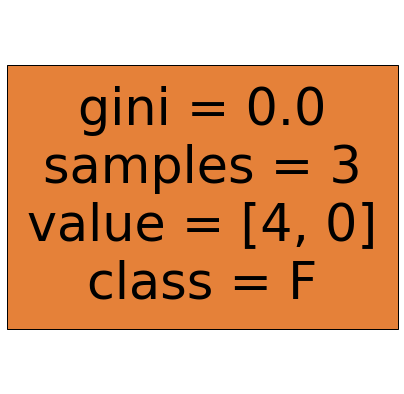

In [211]:
## Plot the first Decision Tree
fig = plt.figure(figsize=(7,7))
_ = tree.plot_tree(clf.estimators_[0], 
                   feature_names=feats,
                   class_names=['F','NF'],
                   filled=True)

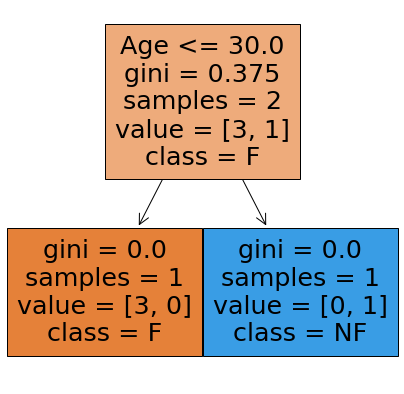

In [212]:
## Plot the second Decision Tree 
fig = plt.figure(figsize=(7,7))
_ = tree.plot_tree(clf.estimators_[1], 
                   feature_names=feats,
                   class_names=['F','NF'],
                   filled=True)

In [213]:
## Print the OOB score
print('Score: ', clf.score(X_train, y_train))

Score:  0.75


Clearly, our Random Forest Classifier is not doing a good job. So let's find the best n_estimators andmax_features to minimize OOB score.

In [218]:
## Performing Grid Search
param_grid = { 
    'n_estimators': [1,2,3,4,5,6,7,8,9,10],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=2)
CV_clf.fit(X_train, y_train)
print(CV_rfc.best_params_)

{'max_features': 'auto', 'n_estimators': 1}


In [239]:
## Fit Random Forest Classifier on the train data
clf = RandomForestClassifier(n_estimators=2, max_features=2, random_state=143, oob_score=True)
clf = clf.fit(X_train, y_train)

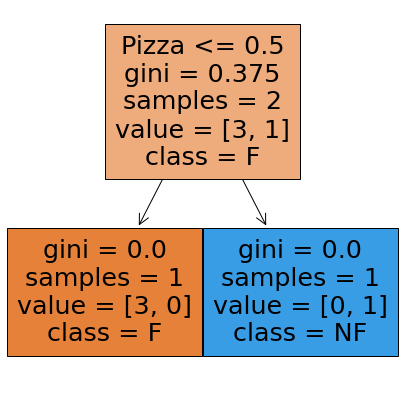

In [240]:
## Plot the first Decision Tree
fig = plt.figure(figsize=(7,7))
_ = tree.plot_tree(clf.estimators_[0], 
                   feature_names=feats,
                   class_names=['F','NF'],
                   filled=True)

In [241]:
## Print the OOB score
print('Score: ', clf.score(X_train, y_train))

Score:  0.5


Although the grid search has reduced the OOB score, the performance of the Random Forest Classifier is still less than the one we manually constructed. This could just be a result of the seed set. We just got lucky with our randomly created bootstrapped datasets!